In [2]:
# !pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.1 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 78.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 89.3 MB/s eta 0:00:00:00:0100:01


In [1]:
import random
from random import sample
import argparse
import numpy as np
import os
import pickle
from tqdm import tqdm
from collections import OrderedDict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import mahalanobis
from scipy.ndimage import gaussian_filter
from skimage import morphology
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.models import wide_resnet50_2, resnet18
import datasets.mvtec as mvtec

/home/studio-lab-user/.conda/envs/padim-anomaly-detection/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# device setup
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

/home/studio-lab-user/.conda/envs/padim-anomaly-detection/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
def parse_args():
    parser = argparse.ArgumentParser('PaDiM')
    parser.add_argument('--data_path', type=str, default='./VisA')
    parser.add_argument('--save_path', type=str, default='./results')
    parser.add_argument('--arch', type=str, choices=['resnet18', 'wide_resnet50_2'], default='resnet18')
    return parser.parse_args([])

def plot_fig(test_img, scores, gts, threshold, save_dir, class_name):
    num = len(scores)
    vmax = scores.max() * 255.
    vmin = scores.min() * 255.
    for i in tqdm(range(num), desc=f"{class_name}:"):
        img = test_img[i]
        img = denormalization(img)
        gt = gts[i].transpose(1, 2, 0).squeeze()
        heat_map = scores[i] * 255
        mask = scores[i]
        mask[mask > threshold] = 1
        mask[mask <= threshold] = 0
        kernel = morphology.disk(4)
        mask = morphology.opening(mask, kernel)
        mask *= 255
        vis_img = mark_boundaries(img, mask, color=(1, 0, 0), mode='thick')
        fig_img, ax_img = plt.subplots(1, 5, figsize=(12, 3))
        fig_img.subplots_adjust(right=0.9)
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        for ax_i in ax_img:
            ax_i.axes.xaxis.set_visible(False)
            ax_i.axes.yaxis.set_visible(False)
        ax_img[0].imshow(img)
        ax_img[0].title.set_text('Image')
        ax_img[1].imshow(gt, cmap='gray')
        ax_img[1].title.set_text('GroundTruth')
        ax = ax_img[2].imshow(heat_map, cmap='jet', norm=norm)
        ax_img[2].imshow(img, cmap='gray', interpolation='none')
        ax_img[2].imshow(heat_map, cmap='jet', alpha=0.5, interpolation='none', vmax=vmax, vmin = vmin)
        ax_img[2].title.set_text('Predicted heat map')
        ax_img[3].imshow(mask, cmap='gray')
        ax_img[3].title.set_text('Predicted mask')
        ax_img[4].imshow(vis_img)
        ax_img[4].title.set_text('Segmentation result')
        left = 0.92
        bottom = 0.15
        width = 0.015
        height = 1 - 2 * bottom
        rect = [left, bottom, width, height]
        cbar_ax = fig_img.add_axes(rect)
        cb = plt.colorbar(ax, shrink=0.6, cax=cbar_ax, fraction=0.046)
        cb.ax.tick_params(labelsize=8)
        font = {
            'family': 'serif',
            'color': 'black',
            'weight': 'normal',
            'size': 8,
        }
        cb.set_label('Anomaly Score', fontdict=font)

        fig_img.savefig(os.path.join(save_dir, class_name + '_{}'.format(i)), dpi=100)
        plt.close()

def denormalization(x):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    x = (((x.transpose(1, 2, 0) * std) + mean) * 255.).astype(np.uint8)
    
    return x

def embedding_concat(x, y):
    B, C1, H1, W1 = x.size()
    _, C2, H2, W2 = y.size()
    s = int(H1 / H2)
    x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
    x = x.view(B, C1, -1, H2, W2)
    z = torch.zeros(B, C1 + C2, x.size(2), H2, W2)
    for i in range(x.size(2)):
        z[:, :, i, :, :] = torch.cat((x[:, :, i, :, :], y), 1)
    z = z.view(B, -1, H2 * W2)
    z = F.fold(z, kernel_size=s, output_size=(H1, W1), stride=s)

    return z

100 100


| feature extraction | train | chewinggum |: 100%|██████████| 4/4 [00:13<00:00,  3.34s/it]
| feature extraction | test | chewinggum |: 100%|██████████| 4/4 [00:12<00:00,  3.23s/it]


pixel ROCAUC: 0.983


chewinggum:: 100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


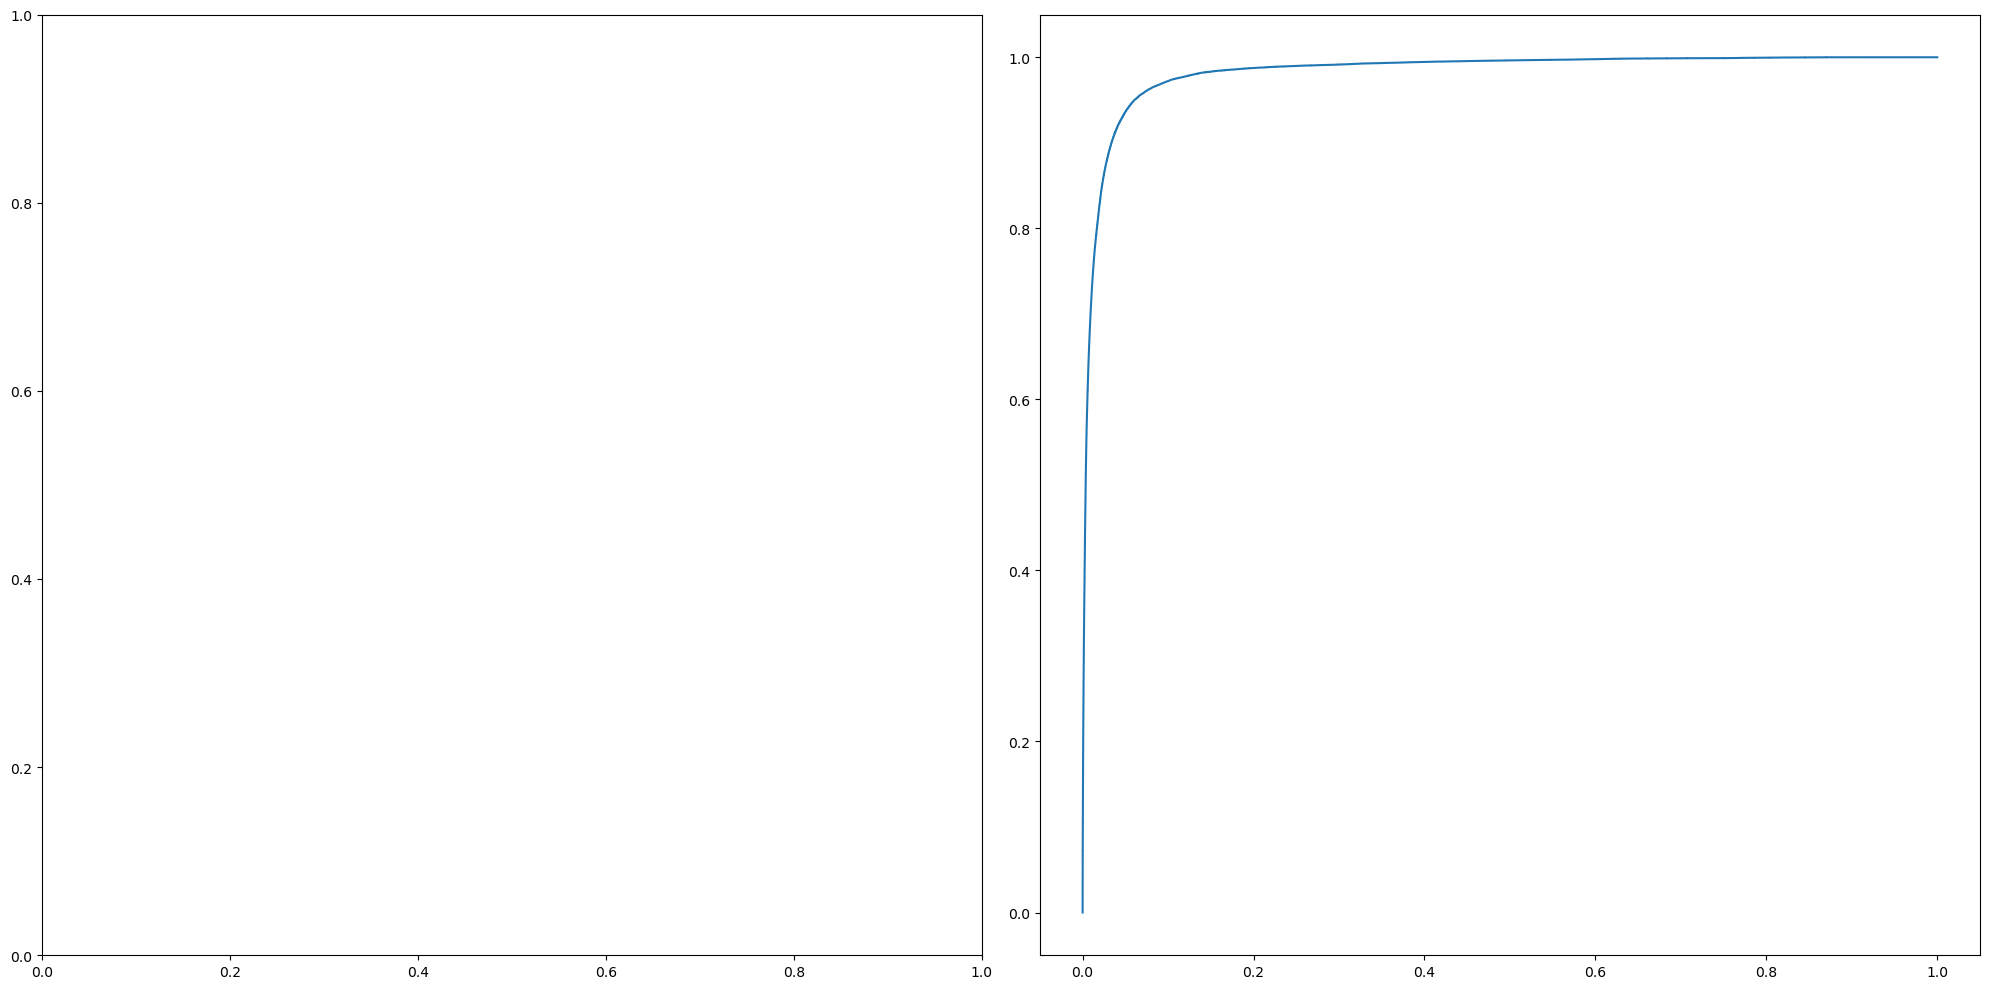

In [4]:
args = parse_args()

# load model
if args.arch == 'resnet18':
    model = resnet18(pretrained=True, progress=True)
    t_d = 448
    d = 100
elif args.arch == 'wide_resnet50_2':
    model = wide_resnet50_2(pretrained=True, progress=True)
    t_d = 1792
    d = 550

model.to(device)
model.eval()
random.seed(1024)
torch.manual_seed(1024)
if use_cuda:
    torch.cuda.manual_seed_all(1024)
    
idx = torch.tensor(sample(range(0, t_d), d))

# set model's intermediate outputs
outputs = []

def hook(module, input, output):
    outputs.append(output)

model.layer1[-1].register_forward_hook(hook)
model.layer2[-1].register_forward_hook(hook)
model.layer3[-1].register_forward_hook(hook)

os.makedirs(os.path.join(args.save_path, 'temp_%s' % args.arch), exist_ok=True)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig_img_rocauc = ax[0]
fig_pixel_rocauc = ax[1]

class_name="chewinggum"

train_dataset = mvtec.MVTecDataset(args.data_path, class_name=class_name, is_train=True)
train_dataloader = DataLoader(train_dataset, batch_size=32, pin_memory=True)
test_dataset = mvtec.MVTecDataset(args.data_path, class_name=class_name, is_train=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, pin_memory=True)

print(len(train_dataset), len(test_dataset))

# train_outputs = OrderedDict([('layer3', [])])
# test_outputs = OrderedDict([('layer3', [])])
train_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])
test_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])

# extract train set features
train_feature_filepath = os.path.join(args.save_path, 'temp_%s' % args.arch, 'train_%s.pkl' % class_name)
if not os.path.exists(train_feature_filepath):
    for (x, _, _) in tqdm(train_dataloader, '| feature extraction | train | %s |' % class_name):
        # model prediction
        with torch.no_grad():
            _ = model(x.to(device))
        # get intermediate layer outputs
        for k, v in zip(train_outputs.keys(), outputs):
            train_outputs[k].append(v.cpu().detach())
        # initialize hook outputs
        outputs = []
    for k, v in train_outputs.items():
        train_outputs[k] = torch.cat(v, 0)

    # Embedding concat
    embedding_vectors = train_outputs['layer1']
    for layer_name in ['layer2', 'layer3']:
        embedding_vectors = embedding_concat(embedding_vectors, train_outputs[layer_name])

    # randomly select d dimension
    # embedding_vectors = torch.index_select(embedding_vectors, 1, idx)
    # calculate multivariate Gaussian distribution
    B, C, H, W = embedding_vectors.size()
    embedding_vectors = embedding_vectors.view(B, C, H * W)
    mean = torch.mean(embedding_vectors, dim=0).numpy()
    cov = torch.zeros(C, C, H * W).numpy()
    I = np.identity(C)
    for i in range(H * W):
        # cov[:, :, i] = LedoitWolf().fit(embedding_vectors[:, :, i].numpy()).covariance_
        cov[:, :, i] = np.cov(embedding_vectors[:, :, i].numpy(), rowvar=False) + 0.01 * I
    # save learned distribution
    train_outputs = [mean, cov]
    # with open(train_feature_filepath, 'wb') as f:
    #     pickle.dump(train_outputs, f)
else:
    print('load train set feature from: %s' % train_feature_filepath)
    with open(train_feature_filepath, 'rb') as f:
        train_outputs = pickle.load(f)

gt_list = []
gt_mask_list = []
test_imgs = []

# extract test set features
for (x, y, mask) in tqdm(test_dataloader, '| feature extraction | test | %s |' % class_name):
    test_imgs.extend(x.cpu().detach().numpy())
    gt_list.extend(y.cpu().detach().numpy())
    gt_mask_list.extend(mask.cpu().detach().numpy())
    # model prediction
    with torch.no_grad():
        _ = model(x.to(device))
    # get intermediate layer outputs
    for k, v in zip(test_outputs.keys(), outputs):
        test_outputs[k].append(v.cpu().detach())
    # initialize hook outputs
    outputs = []
for k, v in test_outputs.items():
    test_outputs[k] = torch.cat(v, 0)

# Embedding concat
embedding_vectors = test_outputs['layer1']
for layer_name in ['layer2', 'layer3']:
    embedding_vectors = embedding_concat(embedding_vectors, test_outputs[layer_name])

# randomly select d dimension
# embedding_vectors = torch.index_select(embedding_vectors, 1, idx)

# calculate distance matrix
B, C, H, W = embedding_vectors.size()
embedding_vectors = embedding_vectors.view(B, C, H * W).numpy()
dist_list = []
for i in range(H * W):
    mean = train_outputs[0][:, i]
    conv_inv = np.linalg.inv(train_outputs[1][:, :, i])
    dist = [mahalanobis(sample[:, i], mean, conv_inv) for sample in embedding_vectors]
    dist_list.append(dist)

dist_list = np.array(dist_list).transpose(1, 0).reshape(B, H, W)

# upsample
dist_list = torch.tensor(dist_list)
score_map = F.interpolate(dist_list.unsqueeze(1), size=x.size(2), mode='bilinear',
                          align_corners=False).squeeze().numpy()

# apply gaussian smoothing on the score map
for i in range(score_map.shape[0]):
    score_map[i] = gaussian_filter(score_map[i], sigma=4)

# Normalization
max_score = score_map.max()
min_score = score_map.min()
scores = (score_map - min_score) / (max_score - min_score)

# calculate image-level ROC AUC score
img_scores = scores.reshape(scores.shape[0], -1).max(axis=1)
gt_list = np.asarray(gt_list)
# fpr, tpr, _ = roc_curve(gt_list, img_scores)
# img_roc_auc = roc_auc_score(gt_list, img_scores)

# print('image ROCAUC: %.3f' % (img_roc_auc))
# fig_img_rocauc.plot(fpr, tpr, label='%s img_ROCAUC: %.3f' % (class_name, img_roc_auc))

# get optimal threshold
gt_mask = np.asarray(gt_mask_list)
gt_mask[gt_mask>0] = 1
precision, recall, thresholds = precision_recall_curve(gt_mask.flatten(), scores.flatten())
a = 2 * precision * recall
b = precision + recall
f1 = np.divide(a, b, out=np.zeros_like(a), where=b != 0)
threshold = thresholds[np.argmax(f1)]

# calculate per-pixel level ROCAUC
fpr, tpr, _ = roc_curve(gt_mask.flatten(), scores.flatten())
per_pixel_rocauc = roc_auc_score(gt_mask.flatten(), scores.flatten())
print('pixel ROCAUC: %.3f' % (per_pixel_rocauc))

fig_pixel_rocauc.plot(fpr, tpr, label='%s ROCAUC: %.3f' % (class_name, per_pixel_rocauc))
save_dir = args.save_path + '/' + f'pictures_{args.arch}/{class_name}'
os.makedirs(save_dir, exist_ok=True)
plot_fig(test_imgs, scores, gt_mask, threshold, save_dir, class_name)

fig.tight_layout()
fig.savefig(os.path.join(args.save_path, f'roc_curve_{class_name}.png'), dpi=100)